compare models trained using per trial and models trained using average trial.

In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_rcnn_k_bl.builder import load_modules

load_modules()

In [4]:
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200502 as param_iterator_obj_per_trial,
    explored_models_20200218 as param_iterator_obj_avg,
    keygen,
)

from thesis_v2.training_extra.data import generate_datasets
from thesis_v2.training_extra.evaluation import eval_fn_wrapper as eval_fn_wrapper_neural
from thesis_v2.training.training import eval_wrapper

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
from torch.backends import cudnn
import torch
cudnn.enabled = True
cudnn.deterministic = True
cudnn.benchmark = False

_data_cache = dict()

_per_trial_data_cache = dict()

from thesis_v2.data.prepared.yuanyuan_8k import get_data, get_data_per_trial, flatten_per_trial_data_one

def get_data_cached(input_size, seed):
    if (input_size, seed) not in _data_cache:
        _data_cache[input_size, seed] = get_data('a', 200, input_size,
                                                 ('042318', '043018', '051018'),
                                                 scale=0.5,
                                                 seed=seed)
    return _data_cache[input_size, seed]

def get_per_trial_data_cached(input_size, seed, seq_length):
    if (input_size, seed, seq_length) not in _per_trial_data_cache:
        _dataset_this = get_data_per_trial('a', 200, input_size,
                                                 ('042318', '043018', '051018'),
                                                 scale=0.5,
                                                 seed=seed, previous_k_frames=seq_length-1)
        _per_trial_data_cache[input_size, seed, seq_length] = tuple(
            [
                flatten_per_trial_data_one(zz) for zz in _dataset_this
            ]
        )
    return _per_trial_data_cache[input_size, seed, seq_length]

In [7]:
def load_everything():
    
    per_trial_model_count = 0
    avg_model_count = 0
    model_tested = 0
    _df_collect = []
    
    for idx, param in enumerate(
        chain(
            param_iterator_obj_per_trial().generate(),
            param_iterator_obj_avg().generate(),
        )
    
    ):
        # remove models that are not fit for comparison.
        # you should get per_trial_model_count 64, avg_model_count 128
        # the doubling comes from 2 model seeds
        if param['kernel_size_l23'] != 3 or param.get('seq_length', 1) != 1 or param['out_channel'] != 16:
            continue
            
#         if param['model_seed'] != 0:
#             continue
        
        if len(param) == 22:
            avg_model_count += 1
            model_type_this = 'avg'
        elif len(param) == 24:
            per_trial_model_count += 1
            model_type_this = 'per_trial'
        else:
            raise RuntimeError
        
        if idx % 10 == 0:
            print(idx)
        
            
        
        assert param['kernel_size_l1'] == 9
        assert param['ff_1st_block']
        
        
        
        assert param['split_seed'] == 'legacy'
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        assert not param['bn_after_fc']
        assert param['rcnn_bl_psize'] == 1
        assert param['rcnn_bl_ptype'] is None
        assert param['input_size'] == 50
        assert param['rcnn_acc_type'] == 'cummean'
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
#         # ok. time to load data and get response.
        
        datasets_avg = get_data_cached(param['input_size'], param['split_seed'])
        datasets_per_trial = get_per_trial_data_cached(param['input_size'], param['split_seed'], 1)

        datasets_dict = {
            'avg': datasets_avg,
            'per_trial': datasets_per_trial,
        }
        
        for dataset_type, dataset_this in datasets_dict.items():
            # create dataset.

            # only the test one is needed.
            datasets_torch_ready = generate_datasets(
                **{
                    'X_train': dataset_this[0].astype(np.float32),
                    'y_train': dataset_this[1],
                    'X_val': dataset_this[2].astype(np.float32),
                    'y_val': dataset_this[3],
                    'X_test': dataset_this[4].astype(np.float32),
                    'y_test': dataset_this[5],
                },
                per_epoch_train=False,
                shuffle_train=False,
            )['test']
            result_on_the_go = eval_wrapper(result['model'].cuda(),
                                            datasets_torch_ready,
                                            'cuda',
                                            1,
                                            partial(eval_fn_wrapper_neural, loss_type=param['loss_type'], yhat_reduce_axis=1),
                                            (lambda dummy1,dummy2,dummy3: torch.tensor(0.0)),
                                            return_responses=False
                                           )
            assert np.asarray(result_on_the_go['corr']).shape == (79,)
            if dataset_type == model_type_this:
                assert abs(result['stats_best']['stats']['test']['corr_mean'] - result_on_the_go['corr_mean']) < 1e-5
                assert abs(result['stats_best']['stats']['test']['corr_mean'] - np.asarray(result_on_the_go['corr']).mean()) < 1e-5
                model_tested += 1
                
            
            _df_collect.append(
                {
                    'model_type': model_type_this,
                    'dataset_type': dataset_type,
                    'act_fn': param['act_fn'],
                    'loss_type': param['loss_type'],
                    'scale': float(param['scale']),
                    'smoothness': float(param['smoothness']),
                    'num_layer': param['num_layer'],
                    'out_channel': param['out_channel'],
                    '1st_bn_before_act': param['ff_1st_bn_before_act'],
                    'rcnn_bl_cls': param['rcnn_bl_cls'],
                    'model_seed': param['model_seed'],
                    'corr_test': ((np.asarray(result_on_the_go['corr'])/cc_max_all_neurons)**2).mean(),
#                     'corr_test': 0.0,
                    'num_param': count_params(result['model']),
                }
            )
                              
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'model_type',
        'dataset_type',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',

        'rcnn_bl_cls',
        'model_seed',

        'corr_test',
        'num_param',
    ])
                              
    df = _df.set_index([
        'model_type',
        'dataset_type',
        'act_fn',
        'loss_type', 'scale', 'smoothness', 'num_layer',
        'out_channel', '1st_bn_before_act',
        'rcnn_bl_cls',
        'model_seed',
    ], verify_integrity=True)                          

    print('per_trial_model_count', per_trial_model_count)
    print('avg_model_count', avg_model_count)
    print('model_tested', model_tested)
    # model_tested should be equal to per_trial_model_count + avg_model_count
    assert model_tested == avg_model_count + per_trial_model_count
                              
    return df

In [8]:
df = load_everything()

0
10
20
30
40
50
60
260
290
450
480
640
870
1030
1060
1220
1250
1410
1440
1600
per_trial_model_count 64
avg_model_count 128
model_tested 192


In [9]:
df['num_param'].unstack('model_type')

model_type                                                                                                           avg  \
dataset_type act_fn   loss_type scale smoothness num_layer out_channel 1st_bn_before_act rcnn_bl_cls model_seed            
avg          relu     mse       0.01  0.000005   2         16          False             1           0           20509.0   
                                                                                                     1           20509.0   
                                                                                         2           0           22845.0   
                                                                                                     1           22845.0   
                                                                                         3           0           22877.0   
                                                                                                     1           22877.0   
                                                                                         4           0           22909.0   
                                                                                                     1           22909.0   
                                                                       True              1           0           20493.0   
                                                                                                     1           20493.0   
                                                                                         2           0           22829.0   
                                                                                                     1           22829.0   
                                                                                         3           0           22861.0   
                                                                                                     1           22861.0   
                                                                                         4           0           22893.0   
                                                                                                     1           22893.0   
                                                 3         16          False             1           0           22845.0   
                                                                                                     1           22845.0   
                                                                                         2           0           27517.0   
                                                                                                     1           27517.0   
                                                                                         3           0           27581.0   
                                                                                                     1           27581.0   
                                                                                         4           0           27645.0   
                                                                                                     1           27645.0   
                                                                       True              1           0           22829.0   
                                                                                                     1           22829.0   
                                                                                         2           0           27501.0   
                                                                                                     1           27501.0   
                                                                                         3           0           27565.0   
                                                                                                     1           27565.0   
                                

In [10]:
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)

In [11]:
# pretty close. so my training worked fine.
corr_mean.unstack('model_type')

model_type                                                                                                 avg  \
dataset_type act_fn   loss_type scale smoothness num_layer out_channel 1st_bn_before_act rcnn_bl_cls             
avg          relu     mse       0.01  0.000005   2         16          False             1            0.599991   
                                                                                         2            0.629926   
                                                                                         3            0.640659   
                                                                                         4            0.645550   
                                                                       True              1            0.600333   
                                                                                         2            0.628196   
                                                                                         3            0.639280   
                                                                                         4            0.640873   
                                                 3         16          False             1            0.644608   
                                                                                         2            0.653714   
                                                                                         3            0.652913   
                                                                                         4            0.650306   
                                                                       True              1            0.644864   
                                                                                         2            0.661909   
                                                                                         3            0.656403   
                                                                                         4            0.656224   
                      poisson   0.01  0.000005   2         16          False             1            0.570437   
                                                                                         2            0.611614   
                                                                                         3            0.618204   
                                                                                         4            0.635702   
                                                                       True              1            0.568237   
                                                                                         2            0.610530   
                                                                                         3            0.616006   
                                                                                         4            0.621710   
                                                 3         16          False             1            0.628480   
                                                                                         2            0.638642   
                                                                                         3            0.649586   
                                                                                         4            0.652415   
                                                                       True              1            0.629603   
                                                                                         2            0.652166   
                                                                                         3            0.642153   
                                                                                         4            0.652893   
             softplus mse       0.01  0.000005   2         16          False             1            0.569307   
          

In [12]:
from scipy.stats import pearsonr

def scatter(x, y, xlabel, ylabel, title):
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())
    print('corr', pearsonr(x, y)[0])
    
# here, I need to check the effective ness of act_fn, bn_before_act, bn_after_fc, loss_type
def check_compare_one_case(series_in, label_to_unstack, values_to_check=None):
    df_unstacked = series_in.unstack(label_to_unstack)
#     assert df_unstacked.shape[1] == 2
    if values_to_check is None:
        values_to_check = df_unstacked.columns.values[:2].tolist()
    else:
        pass
    
    assert len(values_to_check) == 2
    label_x = values_to_check[0]
    label_y = values_to_check[1]
        
    data_x = df_unstacked.loc[:,label_x].values
    data_y = df_unstacked.loc[:,label_y].values
    
    
    
    
    scatter(data_x, data_y, str(label_x), str(label_y), f'{label_to_unstack}: {label_y} vs {label_x}')

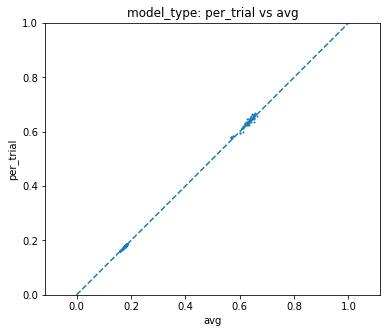

y-x mean 0.0029170076469759096 y-x>0 mean 0.78125
y top 0.6676351803192572 x top 0.6619089146349713
corr 0.999751555592277


In [13]:
check_compare_one_case(corr_mean, 'model_type')